In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from pandas.io.json import json_normalize

## Задание 1.1

In [4]:
db = pd.read_csv("C:/Users/HP/Downloads/TZ_GP.csv", sep=";")

In [5]:
result = pd.json_normalize(db.game_status.apply(json.loads))

In [6]:
db[['coins', 'freeRounds', 'freeUndo', 'freeWildCard', 'freeAddCards',
       'level', 'map', 'bet', 'gladeId', 'league', 'VIPPointsAmount',
       'VIPStatus', 'gameType']] = result[['coins', 'freeRounds', 'freeUndo', 'freeWildCard', 'freeAddCards',
       'level', 'map', 'bet', 'gladeId', 'league', 'VIPPointsAmount',
       'VIPStatus', 'gameType']]

In [7]:
db_new = db.drop(["game_status"], axis=1)

In [8]:
all_users_list = db_new.user_id.unique().tolist()

In [9]:
last_step_user = pd.DataFrame() # отбор последних действий игроков за приведенный период
for i in range(len(all_users_list)):
    a = all_users_list[i]
    last_step_user = last_step_user.append(db_new.query("user_id == @a").sort_values("client_time", ascending=False).head(1)) 

In [10]:
dropped_users = last_step_user.query("gladeId < 2") # игроки, которые не прошли первую грядку

In [11]:
dropped_users_quantity = dropped_users.user_id.shape[0]
drop_rate = dropped_users_quantity/len(all_users_list)
drop_rate, dropped_users_quantity

(0.19247787610619468, 87)

Text(0.5, 1.0, 'Drop rate after first glade')

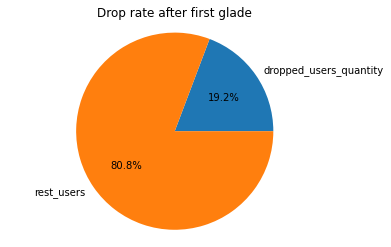

In [12]:
vals = [dropped_users_quantity, len(all_users_list)-dropped_users_quantity]
labels = ['dropped_users_quantity', "rest_users"]

fig, ax = plt.subplots()
ax.pie(vals, labels=labels, autopct='%1.1f%%')
ax.axis("equal")
plt.title("Drop rate after first glade")

Text(0.5, 1.0, 'Events before drop')

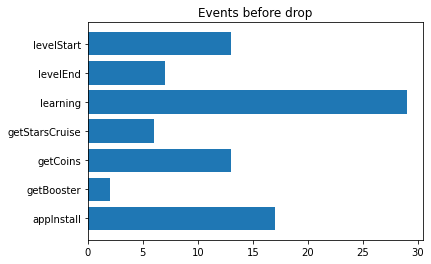

In [13]:
labels = dropped_users.groupby('event_name').count().user_id.index.values
vals = dropped_users.groupby('event_name').count().user_id.values
plt.barh(labels, vals)
plt.title("Events before drop")


In [14]:
dropped_users_with_learning = dropped_users.query("event_name == 'learning'")# дропнутые пользователи с последним шагом learning

In [15]:
event_data_learning = pd.json_normalize(dropped_users_with_learning.event_data.apply(json.loads))

<AxesSubplot:>

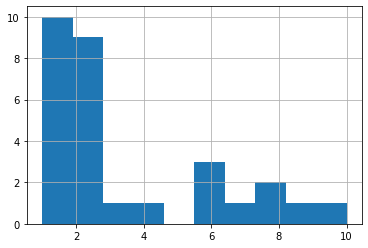

In [16]:
event_data_learning.level.hist() # дроп происходит в основном на первых 2х уровнях

In [17]:
quantity_hints = event_data_learning.groupby('name', as_index=False).count().rename(columns={"level" : "quantity"})

Text(0.5, 1.0, 'Hints before drop')

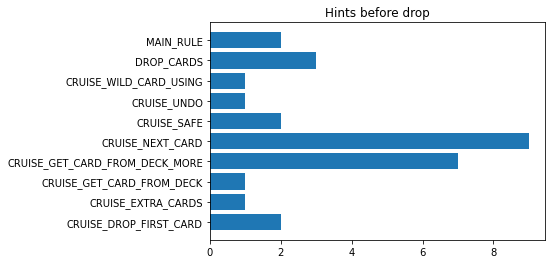

In [18]:
labels = quantity_hints["name"]
vals = quantity_hints["quantity"]
plt.barh(labels, vals)
plt.title("Hints before drop")

## Задание 1.2

In [19]:
level_end_data = pd.json_normalize(db_new.query("event_name == 'levelEnd'").event_data.apply(json.loads))

In [96]:
level_end_data.head()

,time,fromMenu,level,levelLoop,gameType,VIPStatus,win,collectedCoins,bonusCoins,stars,streaksRewards,cardsOnField,cardsOnHands,baseLuckyIndex,targetGoldIndex,totalLuckyIndex,cardsRemainsBonus,prediction,predictionCameTrue
0,32549,False,1,1.0,0,0.0,VICTORY,3088,0,5,"[Gold, AdditionalCard, WildCard, Gold, Additio...",0,17,0,0,0,1580,Default,False
1,45005,False,2,6.0,0,0.0,VICTORY,1214,0,3,"[Gold, AdditionalCard, WildCard]",0,3,0,0,0,90,VictoryWith1Or2Cards,True
2,49074,False,3,7.0,0,0.0,VICTORY_WITH_BOOSTER,1245,0,2,"[Gold, AdditionalCard]",0,5,0,0,0,150,VictoryWith4OrMoreCards,True
3,29419,False,1,1.0,0,0.0,VICTORY,3158,0,5,"[Gold, AdditionalCard, WildCard, Gold, Additio...",0,17,0,0,0,1620,Default,False
4,31960,False,1,1.0,0,0.0,VICTORY,3128,0,5,"[Gold, AdditionalCard, WildCard, Gold, Additio...",0,17,0,0,0,1660,Default,False


In [20]:
level_loops = level_end_data.levelLoop.unique().tolist()
lvloops = pd.DataFrame()
for lvl in level_loops:
    level_quantity = level_end_data.query("levelLoop == @lvl").shape[0]
    result = pd.DataFrame({"levelLoop" : [lvl], 'level_quantity': [level_quantity]})
    lvloops = lvloops.append(result)

In [21]:
first30 = lvloops.sort_values("level_quantity", ascending=False).head(30).levelLoop.tolist()

In [22]:
results_forlvl_loops = pd.DataFrame()
for i in first30:
    a = level_end_data.query("levelLoop == @i & win == 'VICTORY'").shape[0]
    b = level_end_data.query("levelLoop == @i & win == 'VICTORY_WITH_BOOSTER'").shape[0]
    c = level_end_data.query("levelLoop == @i & win == 'DEFEAT'").shape[0]
    d = level_end_data.query("levelLoop == @i & win == 'NONE'").shape[0]
    e = level_end_data.query("levelLoop == @i & win == 'DEFEAT_WITH_BOOSTER'").shape[0]
    abc = pd.DataFrame({"VICTORY" : [a], 'VICTORY_WITH_BOOSTER' : [b], 'DEFEAT' : [c], 'NONE' : [d], 'DEFEAT_WITH_BOOSTER' : [e]})
    results_forlvl_loops = results_forlvl_loops.append(abc)

In [23]:
results_forlvl_loops.index = range(30)
results_forlvl_loops["levelLoop"] = first30

In [24]:
time = level_end_data.groupby("levelLoop", as_index=False).agg({"time" : "mean"})

In [25]:
results_forlvl_loops['victories'] = results_forlvl_loops["VICTORY"] + results_forlvl_loops["VICTORY_WITH_BOOSTER"]
results_forlvl_loops["losses"] = results_forlvl_loops["DEFEAT"] + results_forlvl_loops["DEFEAT_WITH_BOOSTER"]
results_forlvl_loops["attempts"] = results_forlvl_loops["VICTORY"] + results_forlvl_loops["VICTORY_WITH_BOOSTER"]\
+results_forlvl_loops["DEFEAT"] + results_forlvl_loops["DEFEAT_WITH_BOOSTER"] + results_forlvl_loops["NONE"]
results_forlvl_loops["win_ratio"] = results_forlvl_loops["victories"] / results_forlvl_loops["attempts"]
results_forlvl_loops["booster_ratio"] = results_forlvl_loops["VICTORY_WITH_BOOSTER"] / results_forlvl_loops["attempts"]
results_forlvl_loops = results_forlvl_loops.merge(time, on="levelLoop")

In [33]:
data = results_forlvl_loops[["win_ratio", "booster_ratio"]]

In [35]:
X = data.values


In [36]:
from sklearn.preprocessing import StandardScaler
X = data.values
Clus_dataset = StandardScaler().fit_transform(X)
Clus_dataset

array([[-3.99496095,  0.86569118],
       [ 0.81979908, -1.93252849],
       [ 0.76142585, -1.13982877],
       [ 0.59971878, -1.28734413],
       [ 0.86296692, -1.52281463],
       [ 0.9170878 , -1.43517983],
       [ 0.9170878 , -1.66744335],
       [ 0.46775434,  0.81219791],
       [ 0.80238952, -1.42361654],
       [ 0.2795362 ,  0.82980614],
       [ 0.67934955, -0.73919899],
       [ 0.4416113 , -0.18610164],
       [ 0.73480708, -0.25888843],
       [-0.10444374,  0.85902191],
       [ 0.08055803,  0.32257373],
       [ 0.53099714,  0.66190839],
       [ 0.52947109, -0.40974535],
       [-0.00558585,  0.52169943],
       [ 0.9170878 , -1.33868516],
       [-0.57494168,  1.26794006],
       [-0.05250146,  0.3917601 ],
       [-0.68258713,  1.00599968],
       [-0.27542971,  0.66182272],
       [-0.01076618,  0.92959314],
       [-0.09540364,  0.07103153],
       [-0.61520952,  0.49687483],
       [-0.54878706,  0.66718951],
       [-1.95833433,  0.75339568],
       [-0.83956458,

In [37]:
from sklearn.cluster import KMeans
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init=12)
k_means.fit(X)
labels = k_means.labels_
labels

array([1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 2, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1,
       1, 1, 2, 1, 1, 1, 1, 1])

In [95]:
results_forlvl_loops["cluster"] = labels
data["cluster"] = labels
results_forlvl_loops.head()

<ipython-input-95-a5f8f356971d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = labels


,VICTORY,VICTORY_WITH_BOOSTER,DEFEAT,NONE,DEFEAT_WITH_BOOSTER,levelLoop,victories,losses,attempts,win_ratio,booster_ratio,time,cluster
0,1708,7099,3195,288,301,0.0,8807,3496,12591,0.699468,0.563815,148279.771345,1
1,330,4,0,2,0,1.0,334,0,336,0.994048,0.011905,51789.764881,0
2,259,53,1,2,0,6.0,312,1,315,0.990476,0.168254,136419.653968,0
3,260,43,2,4,0,7.0,303,2,309,0.980583,0.139159,54194.022654,0
4,273,28,1,0,0,8.0,301,1,302,0.996689,0.092715,98549.165563,0


In [54]:
means_lvlLoops = results_forlvl_loops.groupby("cluster", as_index=False).agg({"win_ratio" : "mean", "booster_ratio":"mean", "levelLoop":"count"})\
.rename(columns={"win_ratio" : "win_ratio_mean", "booster_ratio":"booster_ratio_mean", "levelLoop" : "quantity"})

In [82]:
means_lvlLoops

,cluster,win_ratio_mean,booster_ratio_mean,quantity
0,0,0.994347,0.103442,8
1,1,0.911905,0.547034,17
2,2,0.971910,0.332995,5


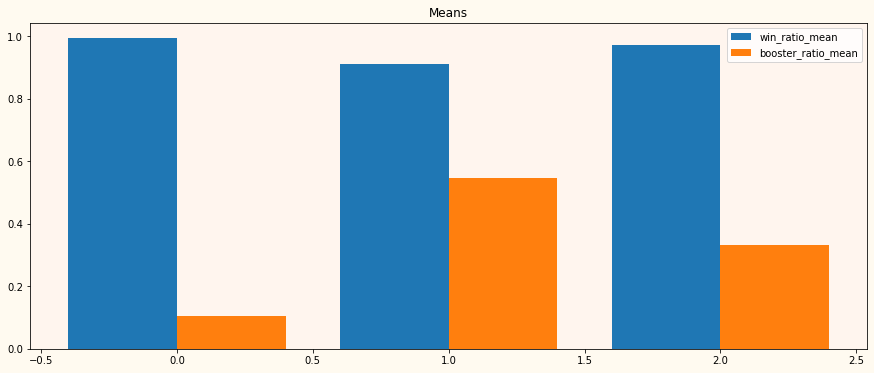

In [75]:
fig, ax = plt.subplots()

ax.bar(means_lvlLoops.cluster - 0.2, means_lvlLoops.win_ratio_mean, width = 0.4)
ax.bar(means_lvlLoops.cluster + 0.2, means_lvlLoops.booster_ratio_mean, width = 0.4)
list123 = ['win_ratio_mean', 'booster_ratio_mean']
ax.set_facecolor('seashell')
fig.set_figwidth(15)    #  ширина Figure
fig.set_figheight(6)    #  высота Figure
fig.set_facecolor('floralwhite')
plt.legend(list123)
plt.title("Means")
plt.show()

In [40]:
import seaborn as sns

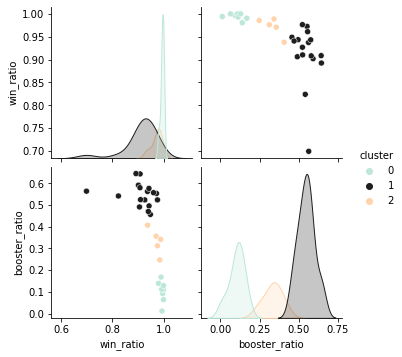

In [81]:
sns.pairplot(data, hue="cluster", palette='icefire')


## Задание 1.3

In [83]:
ad_users = db_new.query("event_name == 'appInstall' & media_source == 'ad-traffic'")

In [84]:
ad_user_list = ad_users.user_id.tolist() # пользователи перешедшие от рекламы

In [85]:
transactions_data = db_new.query("event_name == 'transactionComplete'")

In [94]:
transactions_data.head()

,user_id,media_source,client_time,session_index,event_name,event_data,coins,freeRounds,freeUndo,freeWildCard,freeAddCards,level,map,bet,gladeId,league,VIPPointsAmount,VIPStatus,gameType
396062,60bb7b6e4770af6a2faa05a7,organic,05.06.2021 15:59,3,transactionComplete,"{""inLevel"":false,""usdProceed"":5.24299999999999...",8537,0,1,0,0,110,1,3.0,6.0,0.0,0.0,0.0,NaN
396063,60bb1a304770af6a2faa0575,ad-traffic,06.06.2021 1:18,10,transactionComplete,"{""inLevel"":false,""usdProceed"":1.39199934532658...",4098,0,0,0,0,125,1,2.0,6.0,0.0,0.0,0.0,NaN
396064,60bb1a304770af6a2faa0575,ad-traffic,06.06.2021 4:49,12,transactionComplete,"{""inLevel"":false,""usdProceed"":1.39199934532658...",4020,0,2,0,0,157,1,2.0,7.0,0.0,0.0,0.0,NaN
396065,60bba5ea7c80da6a9442cbf3,ad-traffic,06.06.2021 10:56,25,transactionComplete,"{""inLevel"":false,""usdProceed"":5.24299999999999...",2602,0,0,0,0,132,1,1.0,6.0,0.0,0.0,0.0,NaN
396066,60bae7544770af6a2faa0563,organic,06.06.2021 11:14,36,transactionComplete,"{""inLevel"":false,""usdProceed"":5.24299999999999...",1248,0,0,0,0,219,1,1.0,6.0,0.0,0.0,0.0,NaN


In [87]:
transactions = pd.json_normalize(transactions_data.event_data.apply(json.loads))

In [88]:
transactions.index = transactions_data.index

In [89]:
transactions["user_id"] = transactions_data["user_id"]

In [90]:
sum = 0     #Подсчет суммы денег, потраченной пользователями, пришедшими от рекламы
for i in transactions_data.index:
    if transactions.user_id[i] in ad_user_list:
        sum += transactions.usdProceed[i]

In [91]:
sum

56.57629526528391

In [92]:
ad_cost = len(ad_user_list) * 1.8 # Сумма, затраченная на рекламу
ad_cost

286.2

In [93]:
ad_efficiency = sum/ad_cost # эффективность от рекламы
ad_efficiency

0.19768097576968524